# Analysis of the data regarding the books of the Capitolare libarary
This notebook analyze a data-set conatining the informations regarding the books of the Capitolare library of Verona. It shows how these data can be used for designing a multimodal system for acquiring and digitalizing the books.


## Source of the data
The data-set has been extracted manually from the catlogue of the library __Spagnolo, A., & Marchi, S. (1996). I manoscritti della Biblioteca Capitolare di Verona: catalogo descrittivo. Casa Editrice Mazziana__.
This catalouge was written by don Antonio Spagnolo and corrected in the newer editions. The corrections are written in the catalouge within braces {} we kept the corrected values and ingored the old wrong one.
The index assigned to the codexes is in roman letter but notice 'CM' and 'CD' are not used and 'IIII' is found in some case instead of 'IV', we kept this notation. Some values seems wrong we however kept the original dataset notify the incongruecies in during the analysis. 

## What is missing in the source data
One thing that  unfortunatly is not written in the catalogue is the thikness of the book. This is infact a very important field for the design of the system. 



## Description of the dataset
These are the descriptions of the columns: 

  -  **index_f**: integer index 
  -  **numero_del_codice**: item identifier of the library, it contains the index in capital letters witout parentesis and with the superscripts as capital letters.
  -  **fogli**: number of sheets copied from the text when indicated as ff. or calculated with a positive rounding of this formula number of pages /2 + number of sheets. White sheets are counted.
  -  **altezza**: height of the item
  -  **ampiezza**: widht of the item 
  -  **materiale**: material can be "membranaceo" parchment, "cartaceo" paper or "bombacino" linen paper.
  -  **rilegatura**: can be "rilegato" bounded, "fascicoli" paper files, "fogli sciolti" unbounded sheet.
  -  **palinsesto**: value 1 if the record is a palinsest 
  -  **testo_indistinto**: value 1 if the text is not clearly legible 
  -  **danni_fuoco**: value 1 if the author record fire damage (this attribution may be uncertian)
  -  **cancro_pergamena**: value 1 if damange may be attribute to parchment biological deterioration
  -  **margini_danneggiati**: value 1 if manuscripts have damaged margins
  -  **danni_umidita**: value 1 if the manuscripts has damaged caused by humidity
  -  **restaurato**: value 1 if it has been restored
  -  **dorature**: not used
  -  **colori**: note used
  -  **titolo**: we wrote the title only of a limited ammount of books
  -  **note**: some notes are written in this field.
  
We add a new integer index because we kept separated volumes with the same **numero di codice**. 


In [1]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np 
import pandas as pd
import seaborn as sns
from bokeh.io import output_file, show,output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper#, CategoricalMarkerMapper
from bokeh.palettes import plasma
from bokeh.plotting import figure
paperISOdimension = [
    (420,594,"A2"),
    (297,420,"A3"),
    (210,297,"A4"),
    (148,210,"A5"),
    (105,148,"A6"),
    (74,105,"A7"),
    (52,74,"A8")]


In [2]:
from bokeh.transform import transform

ImportError: No module named transform

In this analysis we will use the **numpy** and **pandas** for the numerial analysis. For vizualizing the data we will firt use **bokeh** this allow us an interactive view for spotting outliers and getting an overwiew of the data, then we will use seaborn and **matplotlib** for visualizing the data on the notebook and matplotlib2tikz for pubblication plot.
We start analzing the completeness of the dataset.

altezza has 76.0% of the values.
ampiezza has 76.0% of the values.
fogli has 75.0% of the values.
materiale has 98.0% of the values.
rilegatura has 99.0% of the values.


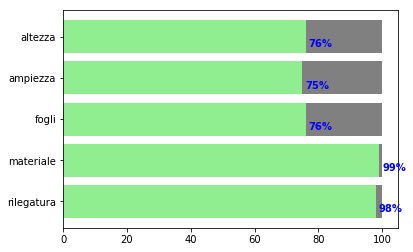

In [3]:
# Load the dataset
data = pd.read_csv('lista manoscritti.csv')
# Calculate completeness
campi = ['altezza','ampiezza','fogli','materiale','rilegatura']
diz = {}
for i in campi:
    diz[i] = round(eval("data.%s.count()/float(data.index_f.count())*100" %(i)))
    print("%s has %s%% of the values." %(i,diz[i]))    
fig = plt.figure()
ax = fig.add_subplot(111)
y_pos = np.arange(len(campi))
percents =  list(diz.values())
ax.barh(y_pos,[100]*len(campi), align='center', color='gray', ecolor='black')
ax.barh(y_pos,percents, align='center', color='lightgreen', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(campi)
for i, v in enumerate(percents):
    ax.text(v + 1, i + .25, ("%s%%")%(int(v)), color='blue', fontweight='bold')
ax.invert_yaxis()  # labels 

### Interpetation
We have aproximately the 76% of the values of widht and height of the books. Some materials is collected in envelopes and they have different width and height this means that variations could be greater. The information regarding the sheets are uncertain: of 75% of the catalogue entries had the number of sheets. The esteem regarding the material and the bounding can be much more precise.

In [4]:
#We add new columns
data['Area_cm2'] = (data.altezza/100)*(data.ampiezza/100)
data['Damaged'] = data.danni_fuoco.fillna(0) + data.cancro_pergamena.fillna(0) + data.danni_umidita.fillna(0) + data.margini_danneggiati.fillna(0)
data['Aspect_ratio'] = data.altezza/data.ampiezza
#One important column is the width when the book is open
data['Width_open_book'] = data.ampiezza*2
#We described the dataset
data.describe()
print(data.Aspect_ratio.iloc[785])
print(data.index_f.iloc[785])
print(data.altezza.iloc[785], data.ampiezza.iloc[785])

14.4744186047
786
(3112.0, 215.0)


In [5]:
data.materiale.value_counts()

cartaceo                992
membraceo               282
bombacino                12
membraceo e cartaceo      2
cartaceo mebraceo         1
Name: materiale, dtype: int64

In [6]:
data.rilegatura.value_counts()

rilegato             1087
fascicoli             110
raccolte di fogli      94
Name: rilegatura, dtype: int64

In [7]:
data.fogli.sum()

143499.0

In [7]:
data.describe()

,index_f,fogli,altezza,ampiezza,palinsesto,testo_indistinto,danni_fuoco,cancro_pergamena,margini_danneggiati,danni_umidita,restaurato,dorature,colori,Area_cm2,Damaged,Aspect_ratio,Width_open_book
count,1309.000000,976.000000,990.000000,990.000000,4,40,4,3,7,16,7,0,1,990.000000,1309.000000,990.000000,990.000000
mean,655.000000,147.027664,263.083838,185.026263,1,1,1,1,1,1,1,NaN,1,5.280275,0.022918,1.441864,370.052525
std,378.020061,127.113526,119.952249,57.472562,0,0,0,0,0,0,0,NaN,NaN,4.007878,0.154723,0.544061,114.945124
min,1.000000,1.000000,67.000000,28.000000,1,1,1,1,1,1,1,NaN,1,0.335000,0.000000,0.568000,56.000000
25%,328.000000,64.000000,215.000000,150.500000,1,1,1,1,1,1,1,NaN,1,3.255975,0.000000,1.357143,301.000000
50%,655.000000,121.000000,240.000000,171.500000,1,1,1,1,1,1,1,NaN,1,4.152350,0.000000,1.420909,343.000000
75%,982.000000,214.250000,300.000000,210.000000,1,1,1,1,1,1,1,NaN,1,6.252500,0.000000,1.459754,420.000000
max,1309.000000,1320.000000,3112.000000,535.000000,1,1,1,1,1,1,1,NaN,1,66.908000,2.000000,14.474419,1070.000000


### Interpetation
The catalouge is composed mainly of paper books (992) and parchments (282). Most of them are bounded. We have four palinsests and 40 books with illegible text, 30 of them are damaged and 7 have been restored. 

In [8]:
TOOLS = "hover,pan,wheel_zoom,box_zoom,reset,save"
source = ColumnDataSource(data=dict(x=data.ampiezza, y=data.altezza, 
                                    cod=data.numero_del_codice,
                                    fogli = data.fogli,
                                    index_f = data.index_f,
                                    titolo = data.titolo,
                                    materiale = data.materiale))

mapper = LinearColorMapper(palette=plasma(256), low=0, high=1307)
#markmapper =CategoricalMarkerMapper(['hex', 'circle_x', 'triangle'])
p = figure(plot_width=900, plot_height=700, tools=TOOLS, title="Width and height of the books",match_aspect=True)
p.circle('x', 'y', size=6, alpha = 0.4, source=source,
         fill_color=transform('index_f', mapper)),
         #marker=transform('materiale',markmapper))
p.xaxis.axis_label = "Width  (mm)"
p.yaxis.axis_label = "Height (mm)"
p.hover.tooltips = [
    ("index", "$index"),
    ("(h,w)", "@y x @x mm"),
    ('Numero del codice', '@cod'),
    ('Fogli','@fogli'),
    ('Titolo','@titolo'),
    ('Materiale','@materiale')
]
output_notebook()
output_file('analisi dimensionale.html')
show(p)

AttributeError: unexpected attribute 'match_aspect' to Figure, possible attributes are above, background_fill_alpha, background_fill_color, below, border_fill_alpha, border_fill_color, css_classes, disabled, extra_x_ranges, extra_y_ranges, h_symmetry, height, hidpi, inner_height, inner_width, js_callbacks, left, lod_factor, lod_interval, lod_threshold, lod_timeout, min_border, min_border_bottom, min_border_left, min_border_right, min_border_top, name, outline_line_alpha, outline_line_cap, outline_line_color, outline_line_dash, outline_line_dash_offset, outline_line_join, outline_line_width, plot_height, plot_width, renderers, right, sizing_mode, tags, title, title_location, tool_events, toolbar, toolbar_location, toolbar_sticky, v_symmetry, webgl, width, x_mapper_type, x_range, y_mapper_type or y_range

We can see some strange items like the item with index 785 (3 meters height) and the with index 788 only 3 cm width.
These are clearly outliers, we'll mask them from the following conputaions.

In [9]:
data.altezza = data.altezza.mask(data.altezza > 1000 )
data.ampiezza = data.ampiezza.mask(data.ampiezza < 40)
# We mask also the measurment thtat derive from this calculation
data.Area_cm2 = data.Area_cm2.mask( data.ampiezza < 40)
data.Area_cm2 = data.Area_cm2.mask(data.altezza > 1000) 
data.Aspect_ratio = data.Aspect_ratio.mask(data.ampiezza < 40)
data.Aspect_ratio = data.Aspect_ratio.mask(data.altezza > 1000)

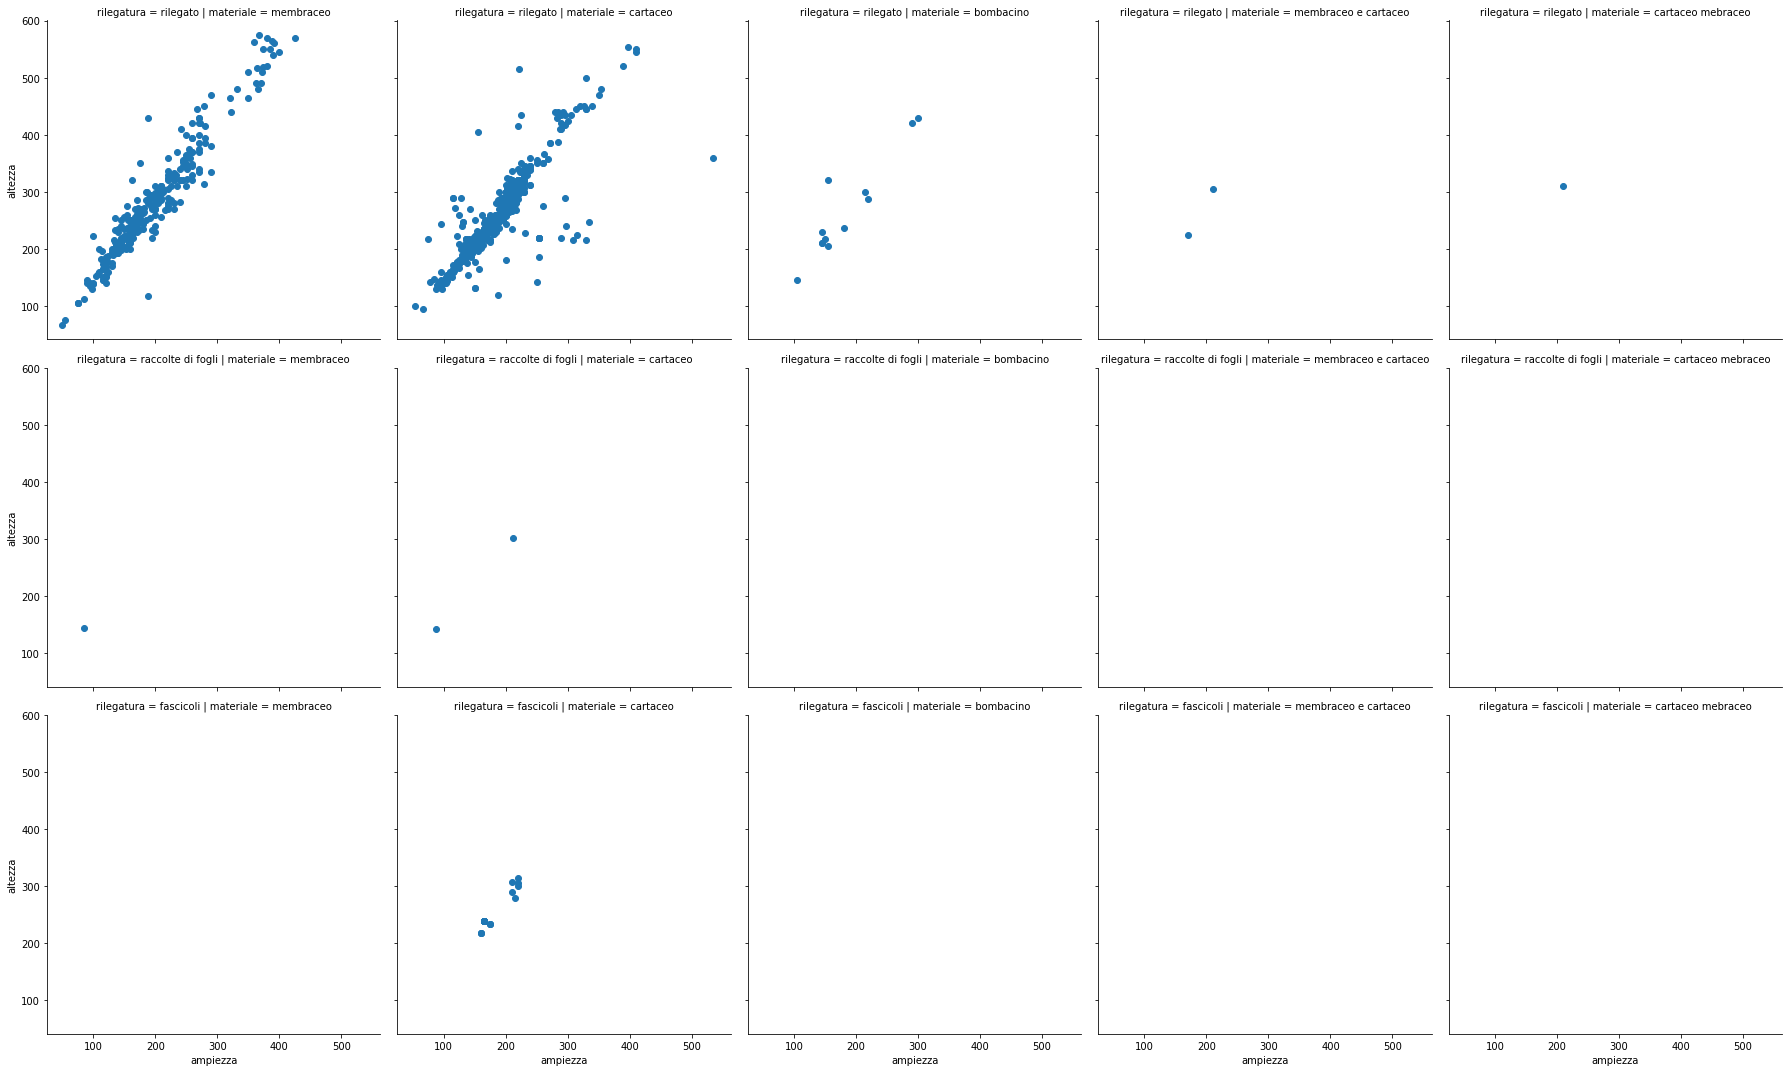

In [10]:
plt.rcParams['figure.figsize'] = (30,10)
grid = sns.FacetGrid(data, col="materiale",row ="rilegatura", palette="tab20c", height=5)
grid.map(plt.scatter, "ampiezza", "altezza", marker="o")
grid.fig.tight_layout(w_pad=1)

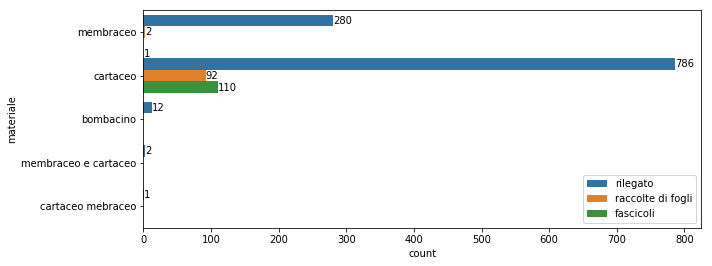

In [11]:
fig, axc = plt.subplots(figsize=(10,4))
sns.countplot(y="materiale", hue="rilegatura", data=data,ax=axc)
#axc.semilogx()
axc.legend(loc='lower right')
#t = axc.set_xticklabels([0,0,1,10,100])

for i in axc.get_children():
    if str(type(i)) == "<class 'matplotlib.patches.Rectangle'>":
        bb = i.get_bbox()
        if np.isnan(bb).any():
            continue
        else:
            axc.text(bb.x1,(bb.y1-bb.y0)/2+bb.y0,  str(int(bb.x1)),verticalalignment='center')

The catalogue shows that most of the parchments are bounded,  the majory of the un-bounded books are made of paper. All the example of bombacino are bounded. We can try to get more accurate esteem of time needed using the number of sheeets.

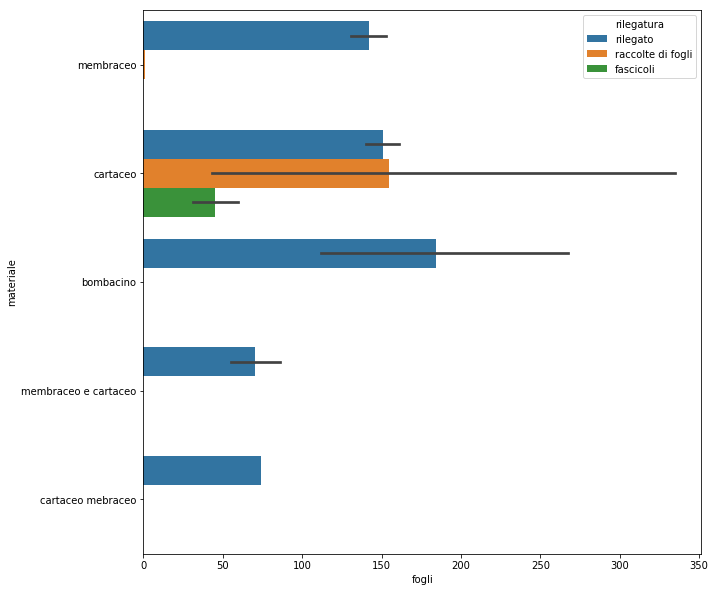

In [15]:
plt.rcParams['figure.figsize'] = (10,10)
ax = sns.barplot(x="fogli", y="materiale",hue="rilegatura", data=data)

We have an average of 150 sheets (300 pages) of parchements or paper in the bounded books. The spare sheets vary a lot depending on the collection. While the files are usually of 50 sheets (100 pages) each. An overall view can be achieved with the scatter plot:

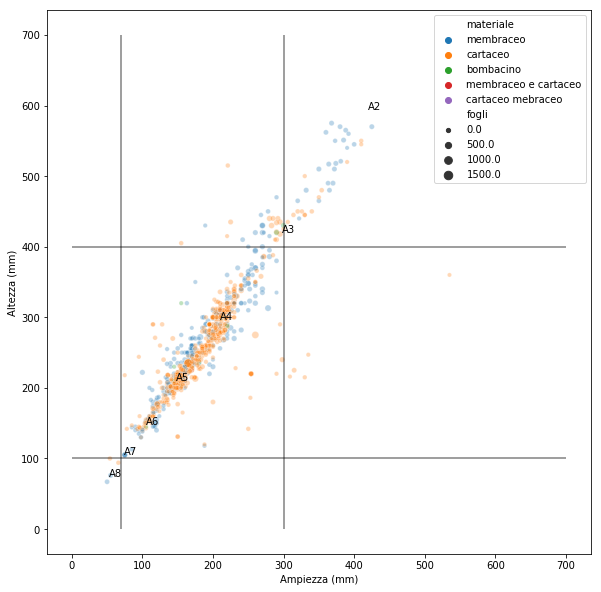

In [30]:
plt.rcParams['figure.figsize'] = (10,10)
ax =sns.scatterplot(x="ampiezza", y="altezza", hue = "materiale", size = "fogli", data=data, alpha = 0.3)
ax.set_aspect('equal')
ax.set_ylabel("Altezza (mm)")
ax.set_xlabel("Ampiezza (mm)")
ax.vlines([70,300],0,700,alpha=0.5)
ax.hlines([100,400],0,700,alpha=0.5)
for i in paperISOdimension:
    ax.text(*i)
    

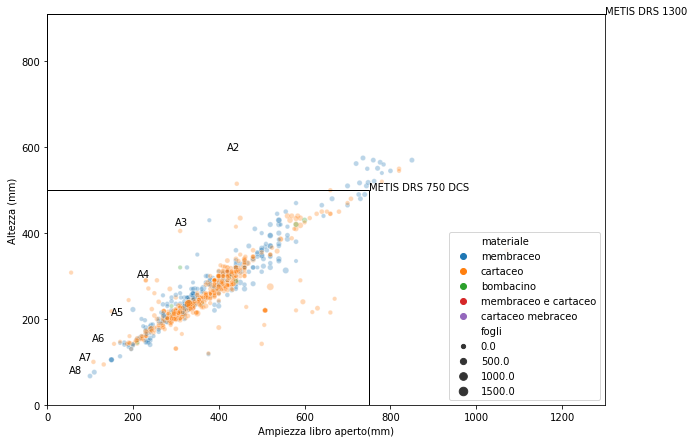

In [40]:
plt.rcParams['figure.figsize'] = (10,10)
ax =sns.scatterplot(x="Width_open_book", y="altezza", hue = "materiale", size = "fogli", data=data, alpha = 0.3)
ax.set_aspect('equal')
ax.set_ylabel("Altezza (mm)")
ax.set_xlabel("Ampiezza libro aperto(mm)")
ax.set_ylim(0,910)
ax.set_xlim(0,1300)
for i in paperISOdimension:
    ax.text(*i)

camera_max_FOV = [
    (1300,910,"METIS DRS 1300"),
    (750,500,"METIS DRS 750 DCS")]

for j in camera_max_FOV:
    ax.add_patch(
         patches.Rectangle(
            (0, 0),
            j[0],
            j[1],
            fill=False      # remove background
         ) )
    ax.text(*j)
plt.legend(loc='lower right')

97.6767676768


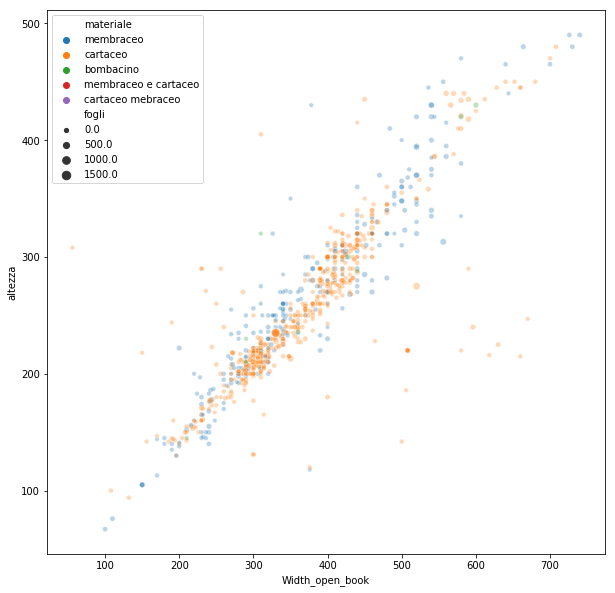

In [20]:
filterd = data[(data.Width_open_book < 750) & (data.altezza < 500)]
print filterd.Width_open_book.count()/float(data.Width_open_book.count())*100
ax =sns.scatterplot(x="Width_open_book", y="altezza", hue = "materiale", size = "fogli", data=filterd, alpha = 0.3)

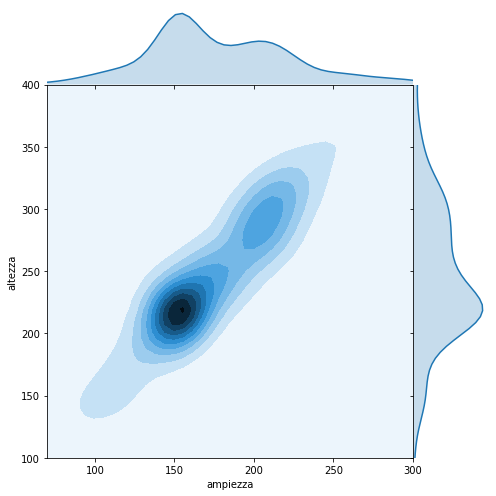

In [37]:
# We get a more precise ditribution of the area.
g = sns.jointplot(data.ampiezza, data.altezza, kind="kde", height=7, space=0,xlim=(70,300),ylim=(100,400))

We can see that the overal distribution of sizes is bi-modala mostly A5 and A4.

1.420908829450676


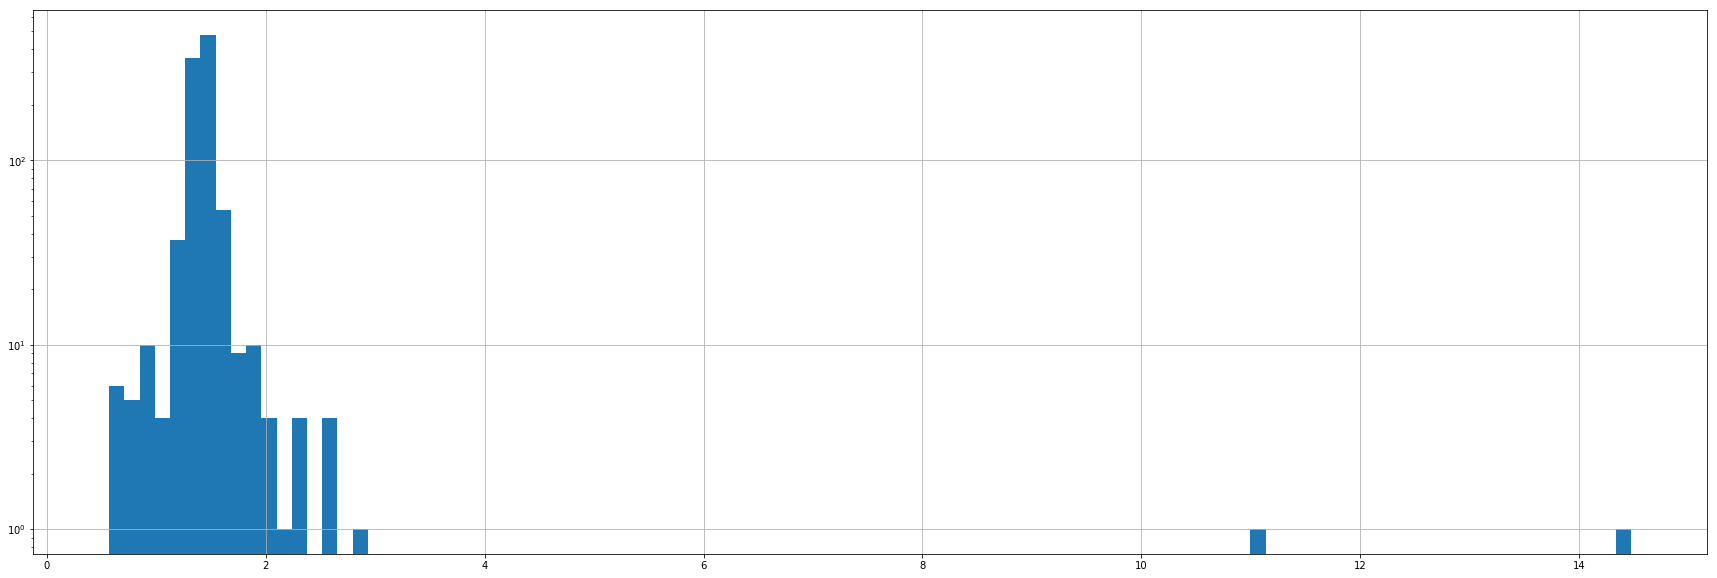

In [116]:
plt.rcParams['figure.figsize'] = (30,10)
ax3 = data.Aspect_ratio.hist(bins=100)
ax3.semilogy()
print(data.Aspect_ratio.median())

[]

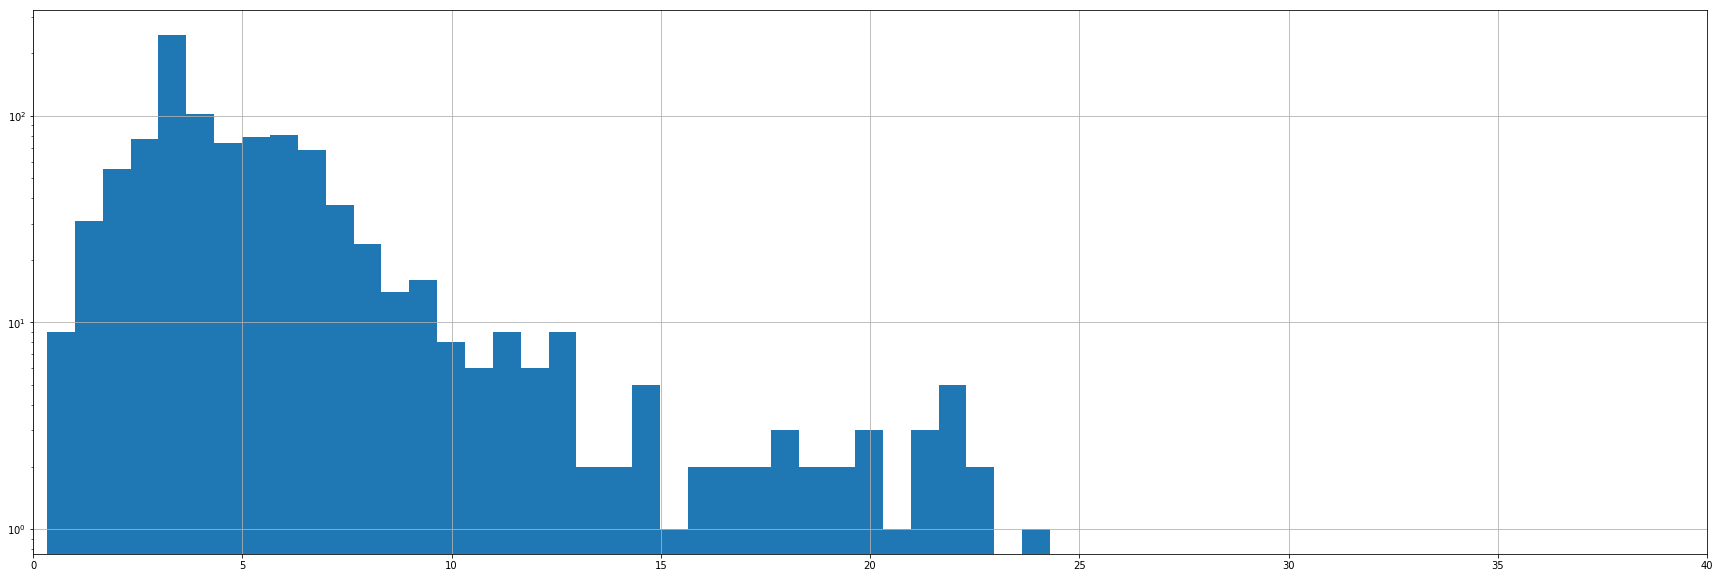

In [60]:
ax2 = data.Area_cm2.hist(bins=100)
ax2.set_xlim(0,40)
ax2.semilogy()